# Global Diferential Privacy Assessement: Univariate case

In this notebook, we will explore the univariate case of the Global Differential Privacy using a dataset from use case 2.1. After running this notebook, you will be able to:
- Understand the concept of Global Differential Privacy.
- Apply Global Differential Privacy to a univariate dataset.

We also run a monte carl simulation to validate the GDP implementation.

## Import data and visualise

The data are imported and only available via 'pipelines' i.e. automations made by a user. As such GDP operates on the user pipeline and not directly on the data.

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
! pip install wget --quiet 
import wget


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [156]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)
clean_data = data[~np.isnan(data)]
print(f"\n\tClean data: {clean_data}")

100% [..........................................................] 39886 / 39886
Original file downloaded.

	Clean data: [178.   155.   169.   157.   171.   166.   167.   175.   165.   160.
 160.   156.   155.   162.   168.   165.   163.   164.   172.   180.
 160.   160.   160.   174.   162.   164.   173.   168.   160.   160.
 170.   185.   177.   177.   182.   175.   165.   175.   180.   165.
  58.   185.     1.65 167.   153.   174.   173.   175.   167.   170.
 178.   185.   172.   157.   172.   157.   171.   163.  ]


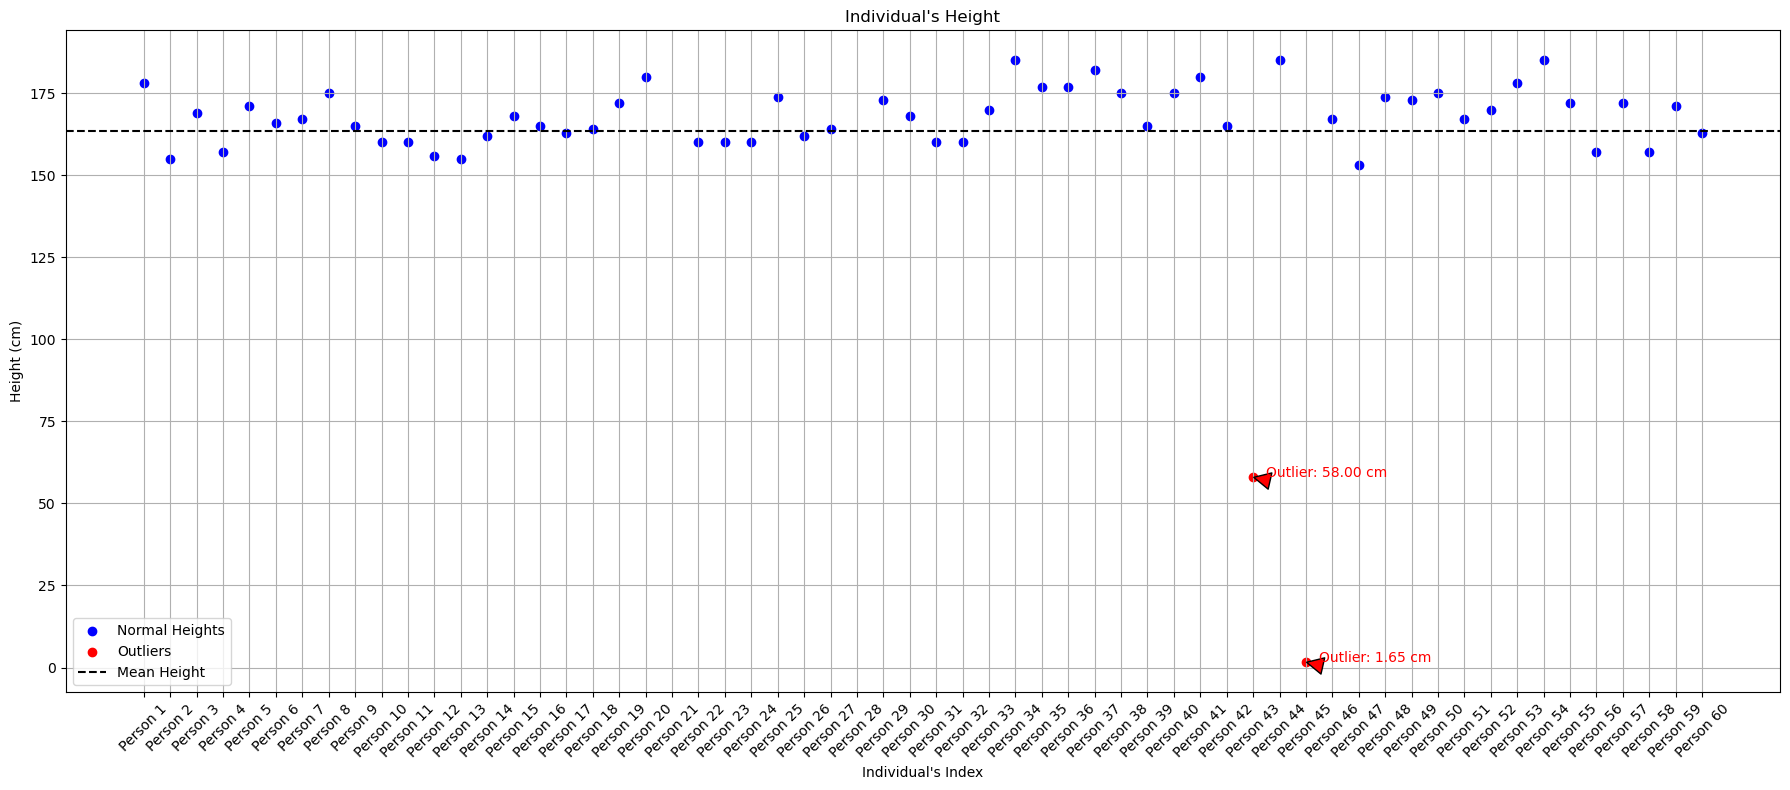

In [157]:
data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)

clean_data = data[~np.isnan(data)]
q1 = np.percentile(clean_data, 25)
q3 = np.percentile(clean_data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
plt.figure(figsize=(18, 8))
normal_indices = [i for i in range(len(data)) if i not in outlier_indices and i not in outlier_indices]
plt.scatter(normal_indices, data[normal_indices], color='blue', label='Normal Heights')
plt.scatter(outlier_indices, data[outlier_indices], color='red', label='Outliers')

for outlier_idx in outlier_indices:
    plt.annotate(f'Outlier: {data[outlier_idx][0]:.2f} cm',
                xy=(outlier_idx, data[outlier_idx]),
                xytext=(outlier_idx+0.5, data[outlier_idx]),
                arrowprops=dict(facecolor='red', shrink=0.05),
                color='red')
plt.axhline(np.nanmean(data), color='black', linestyle='--', label='Mean Height')
plt.title("Individual's Height")
plt.xlabel("Individual's Index")
plt.xticks(range(len(data)), [f"Person {i + 1}" for i in range(len(data))], rotation=45)
plt.ylabel("Height (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Global Differential Privacy

Global Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject calibrated random noise into outputs.

## User Output

A data user has an analysis pipeline that s run on the data. The output of such pipeline is then made differentially private.

Here, the pipeline simply consists in computing the mean.


In [158]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

In [159]:
pipeline_output = user_output(clean_data)
print("the true mean is: ", user_output(clean_data))

the true mean is:  163.42499999999998


## GDP algorithm

The procedure take the user pipeline and data and applies a leave one out (loo) resampling to the data to obtain the influence function, i.e. the output of the user pipeline for each loo resample are compared to the user output. The maximum of that gives the lower bound of the noise to be applied (i.e. it provides the information on the observation which has the largest influence).  



In [160]:
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
print(f"\n\tall loo data: {loo_data}")


	all loo data: [[155. 169. 157. ... 157. 171. 163.]
 [178. 169. 157. ... 157. 171. 163.]
 [178. 155. 157. ... 157. 171. 163.]
 ...
 [178. 155. 169. ... 172. 171. 163.]
 [178. 155. 169. ... 172. 157. 163.]
 [178. 155. 169. ... 172. 157. 171.]]


In [161]:
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"\n\tall loo mean values: {loo_output}")
print(f"\n\tloo for outliers: {loo_output[outlier_indices]}")


	all loo mean values: [163.16929825 163.57280702 163.32719298 163.5377193  163.29210526
 163.37982456 163.3622807  163.22192982 163.39736842 163.48508772
 163.48508772 163.55526316 163.57280702 163.45       163.34473684
 163.39736842 163.43245614 163.41491228 163.2745614  163.13421053
 163.48508772 163.48508772 163.48508772 163.23947368 163.45
 163.41491228 163.25701754 163.34473684 163.48508772 163.48508772
 163.30964912 163.04649123 163.18684211 163.18684211 163.09912281
 163.22192982 163.39736842 163.22192982 163.13421053 163.39736842
 165.2745614  163.04649123 166.26315789 163.3622807  163.60789474
 163.23947368 163.25701754 163.22192982 163.3622807  163.30964912
 163.16929825 163.04649123 163.2745614  163.5377193  163.2745614
 163.5377193  163.29210526 163.43245614]

	loo for outliers: [166.26315789 163.60789474]


In [162]:
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\n\tsensitivity: {sensitivity}")


	sensitivity: 2.8381578947368666


## Sampling from a noise distribution

Of course the noise value has to come from somewhere. Here we choose a Laplace distribution centred on 0 with the scale equal to variance of loo means, ie reflecting how much change we have due to single observations.

In [164]:
loo_scale = np.std(loo_output)
print(f"\n\tnoise scale: {2*loo_scale}")

while True:
    noise = np.random.laplace(loc=0.0, scale=2*loo_scale)
    if abs(noise) >= sensitivity:
        break
print(f"\n\tnoise: {noise}")
dgp_resut = pipeline_output + noise;
print(f"\n\tgdp result: {dgp_resut}")


	noise scale: 0.9484583617228869

	noise: 4.686004285414216

	gdp result: 168.1110042854142


## Validation

Here we use monte carlo simulations to show that the results are differentially private.
Since GDP is defined by the influence of a single observation, we resample the data with replacement (bootstrap) to generate 1000 replicats. For each replicats, the user is asking for leave one out means, which will allow to reconstruct the data if not noisy (see notebook 1). Here, for each of those outpouts, noise is added, and we show that the user cannot reconstruct the data nor even identify outliers.

we start by defining the object dp, which simply add noise as explained above, and reuse this for the user outputs

In [165]:
sample_data = np.random.normal(loc=170, scale=10, size=len(clean_data) - 1)
sample_data = np.append(sample_data, 58)
print(f"Sample data:\n\n {sample_data}")

Sample data:

 [180.75389639 173.09133095 169.37555549 175.94119012 176.24203676
 186.39509268 160.61172433 164.26718282 154.75410238 156.51107679
 166.6884775  168.41461651 160.31458447 159.17944985 173.11725828
 173.37144186 154.83273635 174.95995677 169.83174616 183.99055762
 167.45761748 173.26295724 153.90539123 159.64041791 163.58917742
 163.12513424 176.63084067 159.43917178 172.16469892 156.32742557
 159.78362954 170.65764801 175.7157229  169.98527768 154.20733257
 168.07382878 179.62540508 164.10058146 162.70495551 157.9360464
 166.20848142 162.0571806  183.07240622 172.92140915 159.60616194
 178.22042727 179.44923965 157.69481504 164.44058646 172.77377676
 177.1111956  144.73294537 166.4132818  173.11785289 153.89588864
 158.30602754 160.9506173   58.        ]


## Noise Extraction - Laplace Vs. Gaussian Distribution

Here, we compare noise sampling strategies from Normal and Laplace distributions for use in our DP setting. The goal is to assess how different distributions behave when bounded by a known sensitivity which is estimated via LOO sampling.

loo_output: [172.84300958023462, 175.47254578352872, 174.28424905886928, 173.88135973731426, 174.51064275776713, 173.77025105128254, 174.053092184854, 177.78118897111847, 172.2995807309435, 176.19877790159865], 
pipeline_output: 174.5094697757511

sensitivity: 3.2717191953673534


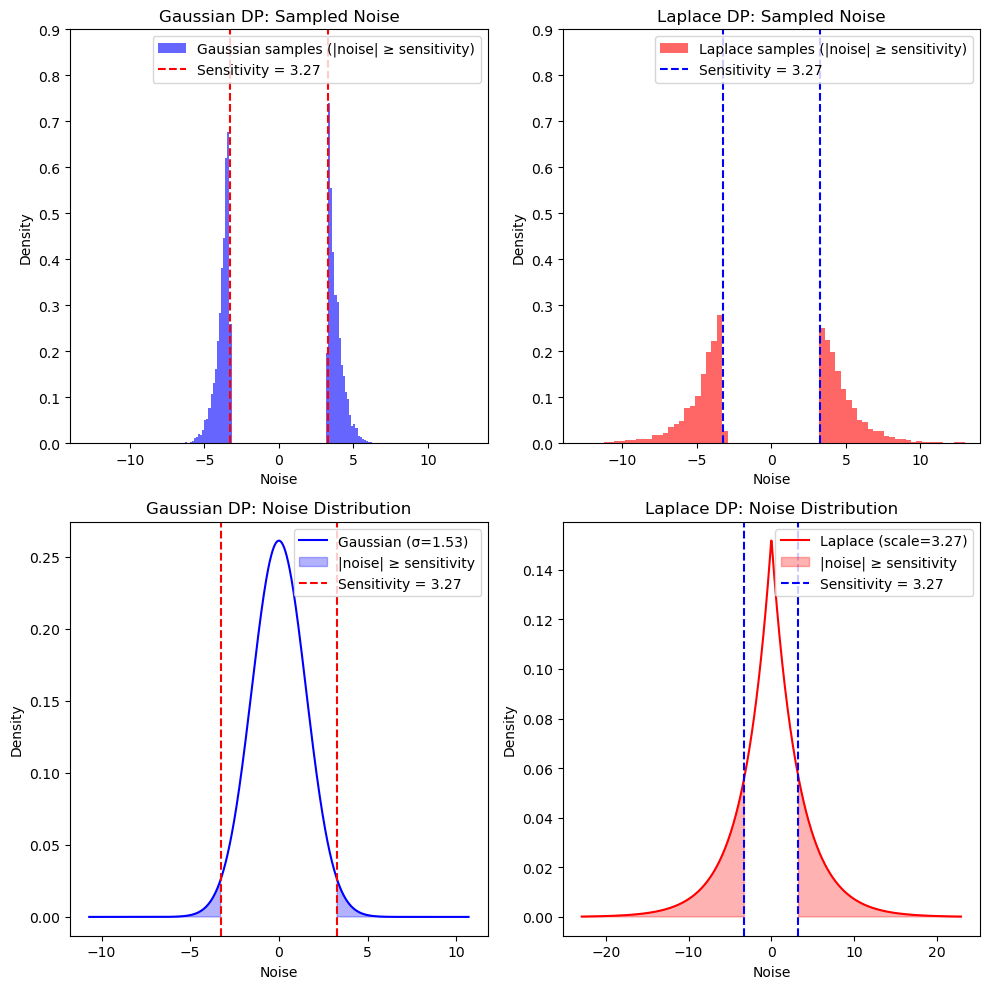

In [171]:
clean_data = np.random.normal(loc=170, scale=10, size=10)
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
pipeline_output = user_output(loo_data)
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"loo_output: {list(loo_output)}, \npipeline_output: {pipeline_output}")
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\nsensitivity: {sensitivity}")
n = len(clean_data)

loo_scale = np.std(loo_output)  
noise_gaussian = []
for _ in range(10000):
    while True:
        noise = np.random.normal(loc=0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian.append(noise)
            break

scale_laplace = sensitivity 
noise_laplace = []
for _ in range(10000):
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_laplace.append(noise)
            break


# VIZ

plt.figure(figsize=(10, 10))  

plt.subplot(2, 2, 1) 
plt.hist(noise_gaussian, bins=100, density=True, alpha=0.6, color='blue', 
         label='Gaussian samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 2)  
plt.hist(noise_laplace, bins=100, density=True, alpha=0.6, color='red', 
         label='Laplace samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Laplace DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 3)  
x_g = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_g, norm.pdf(x_g, 0, loo_scale), 'b-', label=f'Gaussian (σ={loo_scale:.2f})')
plt.fill_between(x_g, norm.pdf(x_g, 0, loo_scale), 
                 where=(np.abs(x_g) >= sensitivity), color='blue', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)  
x_l = np.linspace(-7*scale_laplace, 7*scale_laplace, 1000)
plt.plot(x_l, laplace.pdf(x_l, 0, scale_laplace), 'r-', label=f'Laplace (scale={scale_laplace:.2f})')
plt.fill_between(x_l, laplace.pdf(x_l, 0, scale_laplace), 
                 where=(np.abs(x_l) >= sensitivity), color='red', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Laplace DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

## Different setup for noise 

**Why Use 2 * std for Normal Distribution?**

In a Gaussian distribution, roughly 95% of the data falls within +/- 2 standard deviations. When we're sampling noise, that must exceed a minimum threshold (the sensitivity), a standard deviation that is too small will result in excessive rejection sampling, simply saying, most noise samples are too small and get discarded.

By using 2 * std:

- We increase the spread of the distribution.
- This reduces the rejection rate, allowing more efficient sampling of noise that meets the sensitivity requirement.
- It reflects a practical compromise between privacy guarantees and computational efficiency for tail sampling.

loo_output: [167.35970429602014, 169.95369135077968, 168.8175542248558, 168.72132742869078, 169.31505041356053, 168.62637105125054, 169.7262522761822, 169.51947219407396, 168.11949747787708, 169.06084493276677], 
pipeline_output: 168.92197656460573

sensitivity: 1.5622722685855877


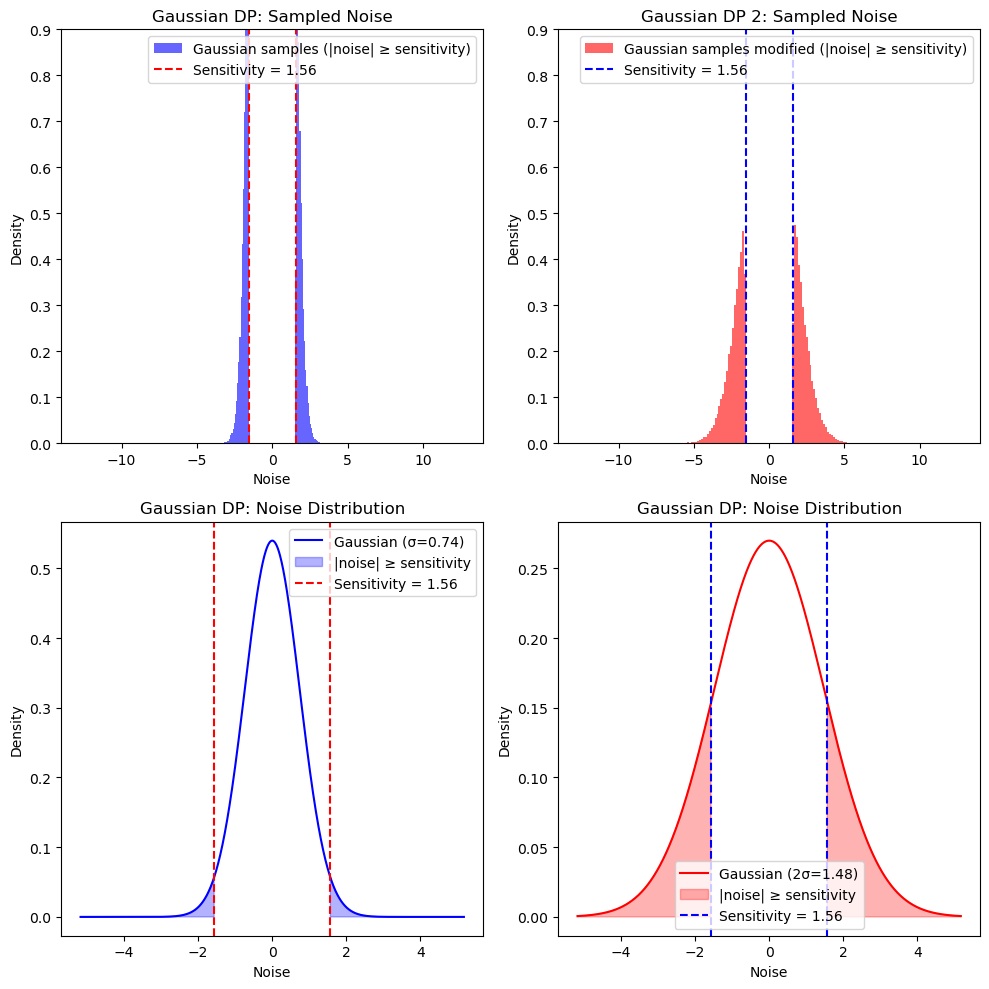

In [185]:
clean_data = np.random.normal(loc=170, scale=10, size=10)
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
pipeline_output = user_output(loo_data)
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"loo_output: {list(loo_output)}, \npipeline_output: {pipeline_output}")
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\nsensitivity: {sensitivity}")

n = len(clean_data)

loo_scale = np.std(loo_output)  
#scale = max(loo_scale, sensitivity / np.sqrt(2 * np.log(1.1)))  
noise_gaussian = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian.append(noise)
            break

noise_gaussian_2 = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=2 * loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian_2.append(noise)
            break



# VIZ
plt.figure(figsize=(10, 10))  

plt.subplot(2, 2, 1) 
plt.hist(noise_gaussian, bins=100, density=True, alpha=0.6, color='blue', 
         label='Gaussian samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 2)  
plt.hist(noise_gaussian_2, bins=100, density=True, alpha=0.6, color='red', 
         label='Gaussian samples modified (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Gaussian DP 2: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 3)  
x_g = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_g, norm.pdf(x_g, 0, loo_scale), 'b-', label=f'Gaussian (σ={loo_scale:.2f})')
plt.fill_between(x_g, norm.pdf(x_g, 0, loo_scale), 
                 where=(np.abs(x_g) >= sensitivity), color='blue', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)  
x_l = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_l, norm.pdf(x_l, 0, 2 * loo_scale), 'r-', label=f'Gaussian (2σ={(2*loo_scale):.2f})')
plt.fill_between(x_g, norm.pdf(x_l, 0, 2*loo_scale), 
                 where=(np.abs(x_l) >= sensitivity), color='red', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Main Pipeline

In [196]:
def dp(clean_data,pipeline_output):


    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise = np.random.normal(loc=0.0, scale=2 * loo_scale)
        if abs(noise) >= sensitivity:
            break

    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity


In [197]:
def iqr_bounds(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return iqr, lower_bound, upper_bound

#def outlier_(recons, orig):
#    return isclose(recons, orig, rel_tol=1e-3)
def outlier_(value, lower, upper):
    return value < lower or value > upper
    
n_replicates = 1000
subsample_sizes = [20, 40, 60, 80, 100]

id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
counts = {size: 0 for size in subsample_sizes}
reconstructed = {size: [] for size in subsample_sizes}
true_means_ = {size: [] for size in subsample_sizes}
sensitivities_ = {size: [] for size in subsample_sizes}
error_ = {size: [] for size in subsample_sizes}

for _ in range(n_replicates):
    
    data = np.random.normal(loc=170, scale=10, size=100)
    for size in subsample_sizes:
        original_subsample = data[:size].copy()
        iqr_orig, lower_orig, upper_orig = iqr_bounds(original_subsample)
        outlier_value = lower_orig - 100
        subsample_w = original_subsample.copy()
        subsample_w[0] = outlier_value
        true_mean = np.mean(subsample_w)
        true_means_[size].append(true_mean)
        loo_data = np.array([np.delete(subsample_w, i) for i in range(len(subsample_w))])
        ######## PIPELINE ########
        noisy_outputs = []
        sens_outputs = []
        for loo_subset in loo_data:
            user_output_ = user_output(loo_subset)
            noisy_output, sensitivity_ = dp(loo_subset, user_output_)
            noisy_outputs.append(noisy_output)
            sens_outputs.append(sensitivity_)
        ######## RECONSTRUCTION ########
        coeff_mat = np.ones((size, size)) - np.eye(size)
        recons = np.linalg.solve(coeff_mat, (size - 1) * np.array(noisy_outputs))

        recons_error = np.mean(abs(recons - original_subsample))
        error_[size].append(recons_error)
        sensitivities_[size].append(sens_outputs)
        reconstructed[size].append(recons)
   
        #if outlier_(recons[0], original_subsample[0]):
        #    counts[size] += 1

        _, lower_rec, upper_rec = iqr_bounds(recons)
        if outlier_(recons[0], lower_rec, upper_rec):
            counts[size] += 1
            
        for idx in range(size):
            #if outlier_(recons[idx], original_subsample[idx]):
            if outlier_(recons[idx], lower_rec, upper_rec):
                id_dr[size][idx] += 1


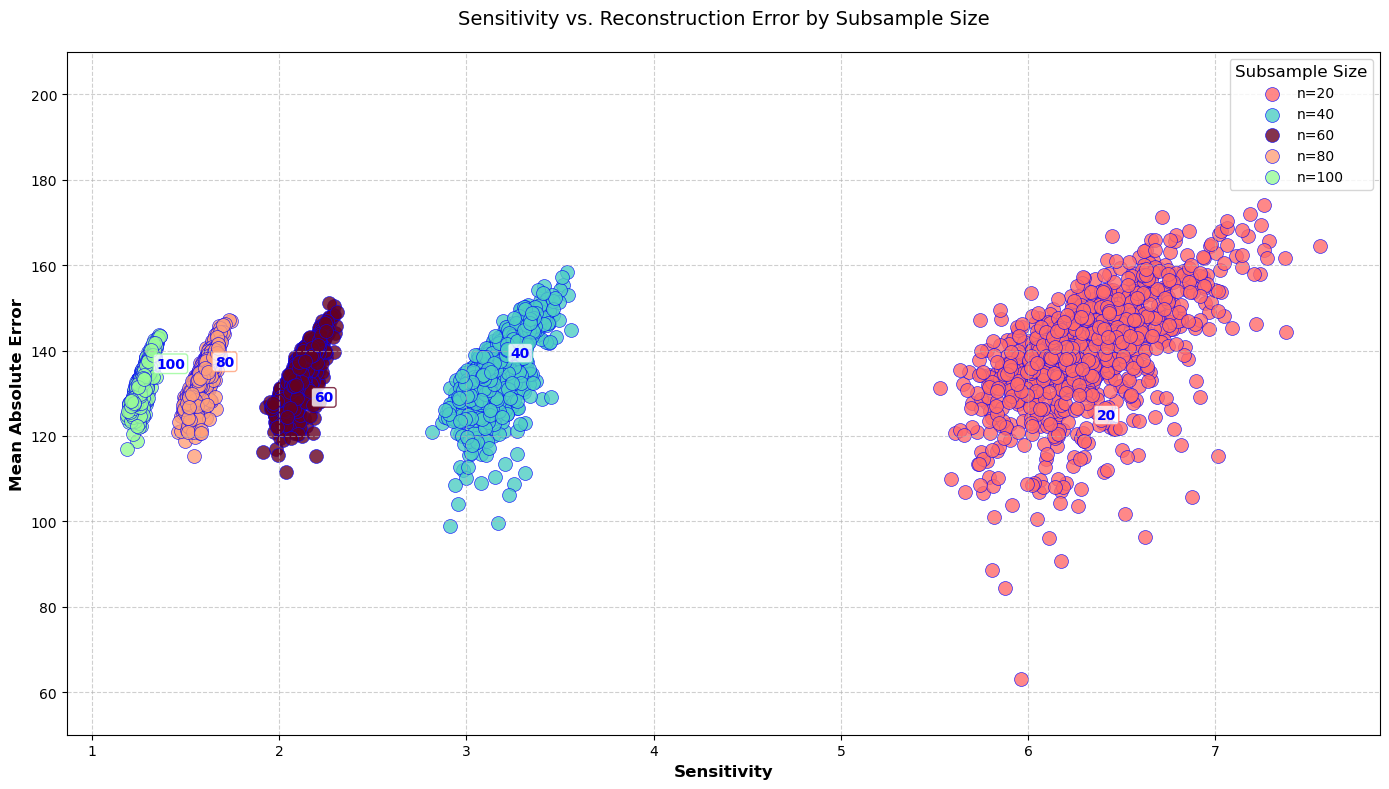

In [198]:
# https://matplotlib.org/stable/users/explain/colors/colors.html
color_map = {
    20: '#FF6B6B',  
    40: '#4ECDC4', 
    60: '#650021', 
    80: '#FFA07A',  
    100: '#98FB98' 
}

plt.figure(figsize=(14, 8))

for size in subsample_sizes:
    mean_sensitivity = np.mean(np.array(sensitivities_[size]), axis=1)
    plt.scatter(mean_sensitivity, 
                np.array(error_[size]),
                color=color_map[size],
                s=100,  
                alpha=0.8,
                edgecolors='b',  
                linewidth=0.5,
                label=f'n={size}')

    median_idx = np.argsort(mean_sensitivity)[len(mean_sensitivity)//2]
    plt.annotate(f'{size}',
                 xy=(mean_sensitivity[median_idx], np.array(error_[size])[median_idx]),
                 xytext=(10, 10),  
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color="b", 
                 bbox=dict(boxstyle='round,pad=0.2', 
                          fc='white', 
                          ec=color_map[size],  
                          alpha=0.8))

plt.ylim(50, 210)
plt.xlabel('Sensitivity', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.title('Sensitivity vs. Reconstruction Error by Subsample Size', 
          fontsize=14, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Subsample Size', title_fontsize=12)

plt.tight_layout()
plt.show()

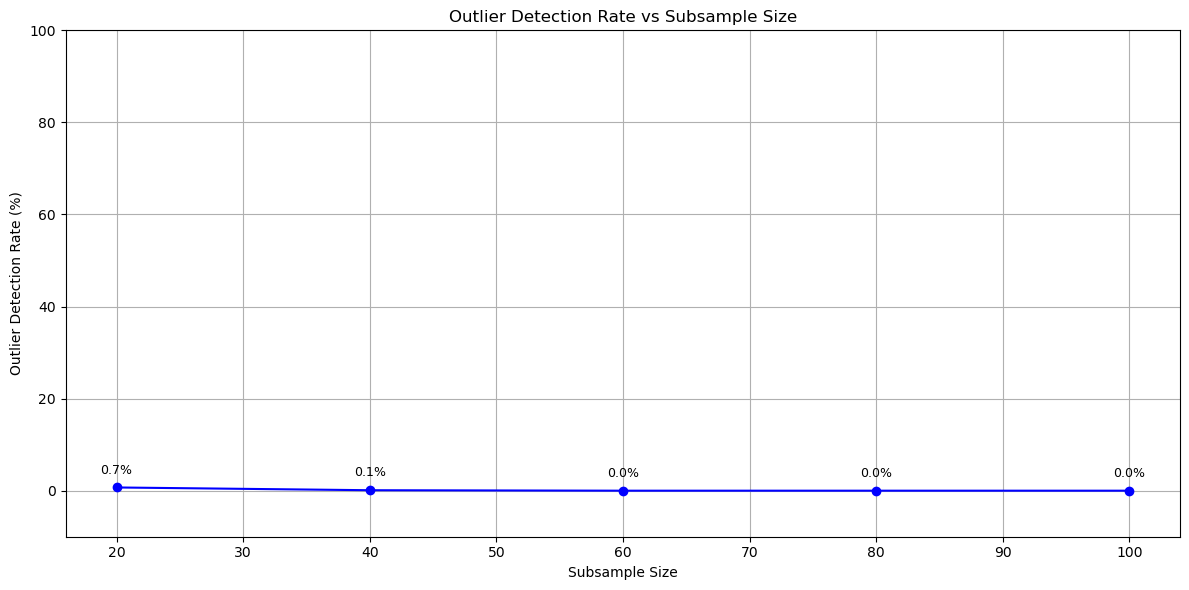

In [199]:
detection_rates = [(counts[size] / n_replicates) * 100 for size in subsample_sizes]

plt.figure(figsize=(12, 6))
plt.plot(subsample_sizes, detection_rates, marker='o', linestyle='-', color='blue')

for size, rate in zip(subsample_sizes, detection_rates):
    plt.annotate(
        f"{rate:.1f}%",
        (size, rate),    
        textcoords="offset points",  
        xytext=(0, 10),  
        ha='center',      
        fontsize=9       
    )

plt.xlabel('Subsample Size')
plt.ylabel('Outlier Detection Rate (%)')
plt.title('Outlier Detection Rate vs Subsample Size')
plt.ylim(-10, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

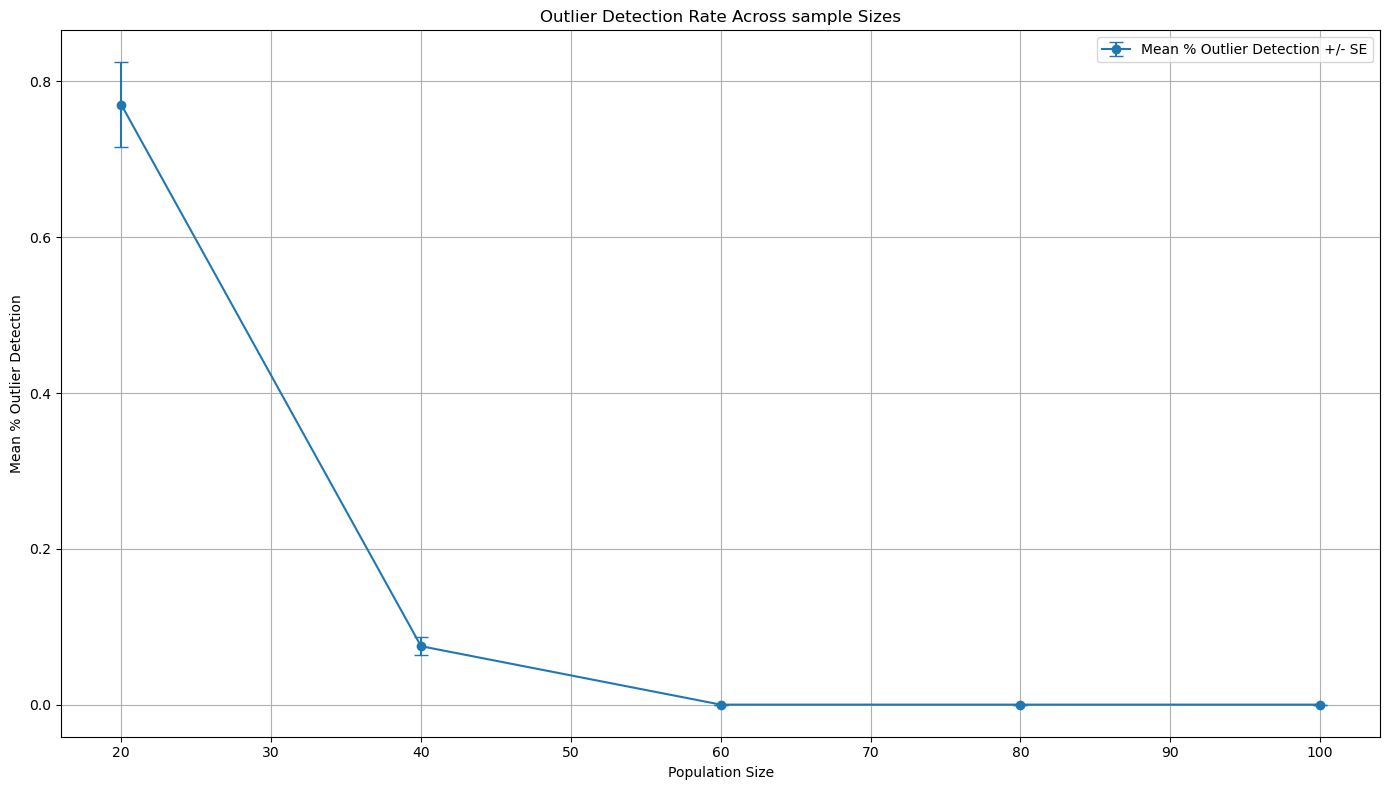

In [200]:
# (1) compute the percentage of time subject 1, 2, 3 etc were flagged outliers 
# (2) average these values along with the strandard error (for n=20, n=40, etc) and 
# (3) add the mean with standard error to the outlier detection plot
means, errors, pop_size = list(), list(), list()

for n, flags in id_dr.items():
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    se = np.std(percentages, ddof=1) / np.sqrt(len(flags))
    means.append(mean)
    errors.append(se)
    pop_size.append(n)

plt.figure(figsize=(14, 8))
plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, label='Mean % Outlier Detection +/- SE')
plt.title('Outlier Detection Rate Across sample Sizes')
plt.xlabel('Population Size')
plt.ylabel('Mean % Outlier Detection')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The outlier detection here refers to how often the injected noise produces an output that is statistically flagged as an outlier.

What this plot shows, is that across all subsample sizes, the outlier detection rate remains consistently at 0%. This means the added noise never creates anomalous or suspicious values, regardless of how large or small the sample is. The mechanism produces outputs that remain statistically plausible and naturally blend in with expected values.

However since the method is foundamentally based on randomness, and earlier we mentioned that smaller datasets are more sensetive, we can expect information breach in small datasets. 

### Comparison to local privacy

Local privacy is something that one is more accustomed to. We simply have to add noise on each subject. Of course in project in which the data are completely private this is not possible, which is why gobal privacy can be used. It is however beneficial to compare the approach and results here.

We start by creating the local_dp object which noise data rahter than user_output

In [201]:
def local_dp(clean_data):

    # now this is simply how far a subject is to the user_output
    sensitivity = np.abs(clean_data-user_output(clean_data))

    noise_values = np.zeros_like(clean_data)
    for i in range(len(clean_data)):
        while True:
            noise = np.random.normal(loc=0.0, scale=sensitivity[i], size=1)
            if abs(noise[0]) >= sensitivity[i]:
                noise_values[i] = noise[0]
                break
    noisy_data = clean_data + noise_values
    return noisy_data, sensitivity

In [202]:
n_replicates = 1000
subsample_sizes = [20, 40, 60, 80, 100]

id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
counts = {size: 0 for size in subsample_sizes}
reconstructed = {size: [] for size in subsample_sizes}
true_means_ = {size: [] for size in subsample_sizes}
sensitivities_ = {size: [] for size in subsample_sizes}
error_ = {size: [] for size in subsample_sizes}

for _ in range(n_replicates):
    
    data = np.random.normal(loc=170, scale=10, size=100)
    for size in subsample_sizes:
        original_subsample = data[:size].copy()
        iqr_orig, lower_orig, upper_orig = iqr_bounds(original_subsample)
        outlier_value = lower_orig - 100
        subsample_w = original_subsample.copy()
        subsample_w[0] = outlier_value
        true_mean = np.mean(subsample_w)
        true_means_[size].append(true_mean)
        loo_data = np.array([user_output(np.delete(subsample_w, i)) for i in range(len(subsample_w))])
        ######## PIPELINE ########
        noisy_output, sensitivity_ = local_dp(loo_data)
        sensitivities_[size].append(sensitivity_)
        ######## RECONSTRUCTION ########
        n = size
        recons = np.linalg.solve(np.ones((n, n)) - np.eye(n), (n - 1) * np.array(noisy_output).flatten())
        recons_error = np.mean(abs(recons - original_subsample))
        error_[size].append(recons_error)
        reconstructed[size].append(recons)
        _, lower_rec, upper_rec = iqr_bounds(recons)
        if outlier_(recons[0], lower_rec, upper_rec):
            counts[size] += 1
            
        for idx in range(size):
            #if outlier_(recons[idx], original_subsample[idx]):
            if outlier_(recons[idx], lower_rec, upper_rec):
                id_dr[size][idx] += 1


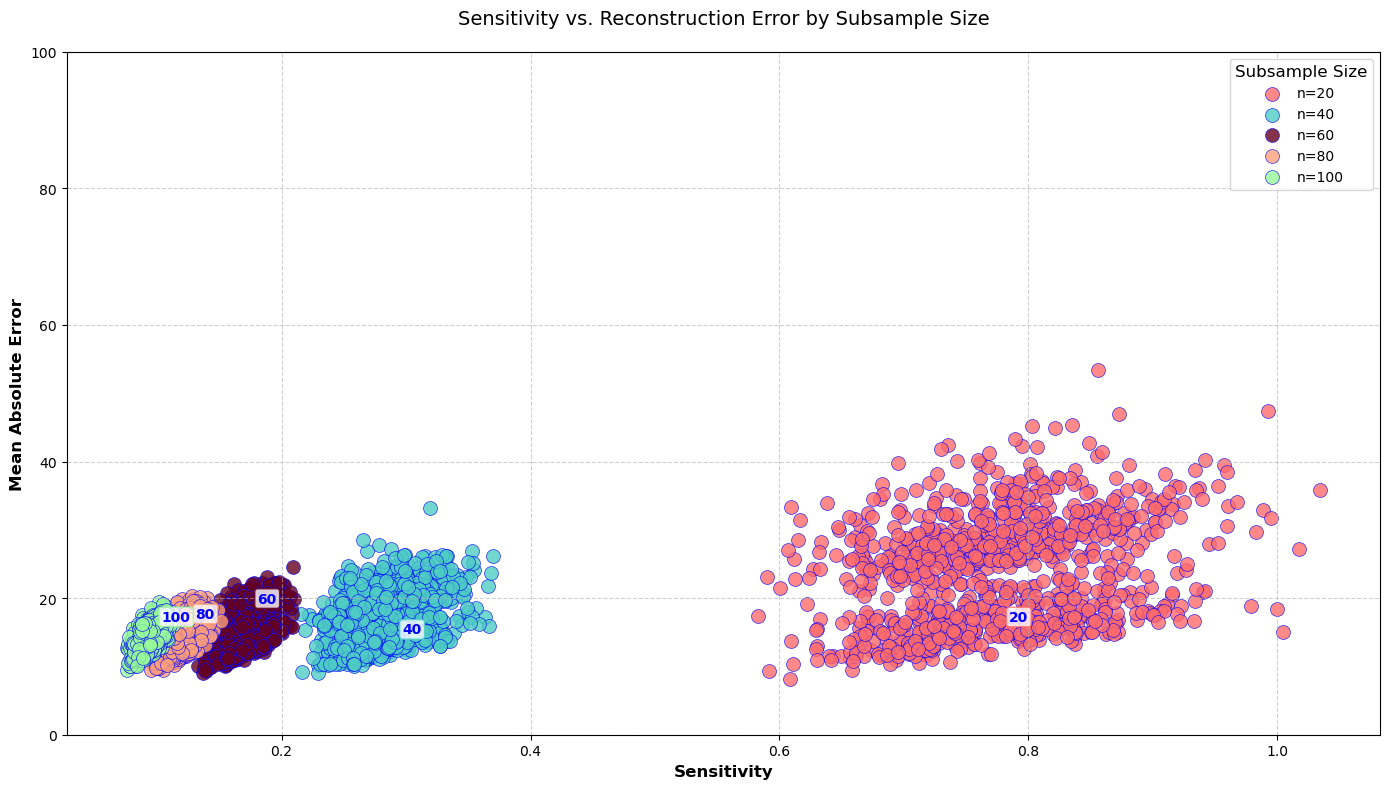

In [203]:
# https://matplotlib.org/stable/users/explain/colors/colors.html
color_map = {
    20: '#FF6B6B',  
    40: '#4ECDC4', 
    60: '#650021', 
    80: '#FFA07A',  
    100: '#98FB98' 
}

plt.figure(figsize=(14, 8))

for size in subsample_sizes:
    mean_sensitivity = np.mean(np.array(sensitivities_[size]), axis=1)
    plt.scatter(mean_sensitivity, 
                np.array(error_[size]),
                color=color_map[size],
                s=100,  
                alpha=0.8,
                edgecolors='b',  
                linewidth=0.5,
                label=f'n={size}')

    median_idx = np.argsort(mean_sensitivity)[len(mean_sensitivity)//2]
    plt.annotate(f'{size}',
                 xy=(mean_sensitivity[median_idx], np.array(error_[size])[median_idx]),
                 xytext=(10, 10),  
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color="b", 
                 bbox=dict(boxstyle='round,pad=0.2', 
                          fc='white', 
                          ec=color_map[size],  
                          alpha=0.8))

plt.ylim(0, 100)
plt.xlabel('Sensitivity', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.title('Sensitivity vs. Reconstruction Error by Subsample Size', 
          fontsize=14, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Subsample Size', title_fontsize=12)

plt.tight_layout()
plt.show()

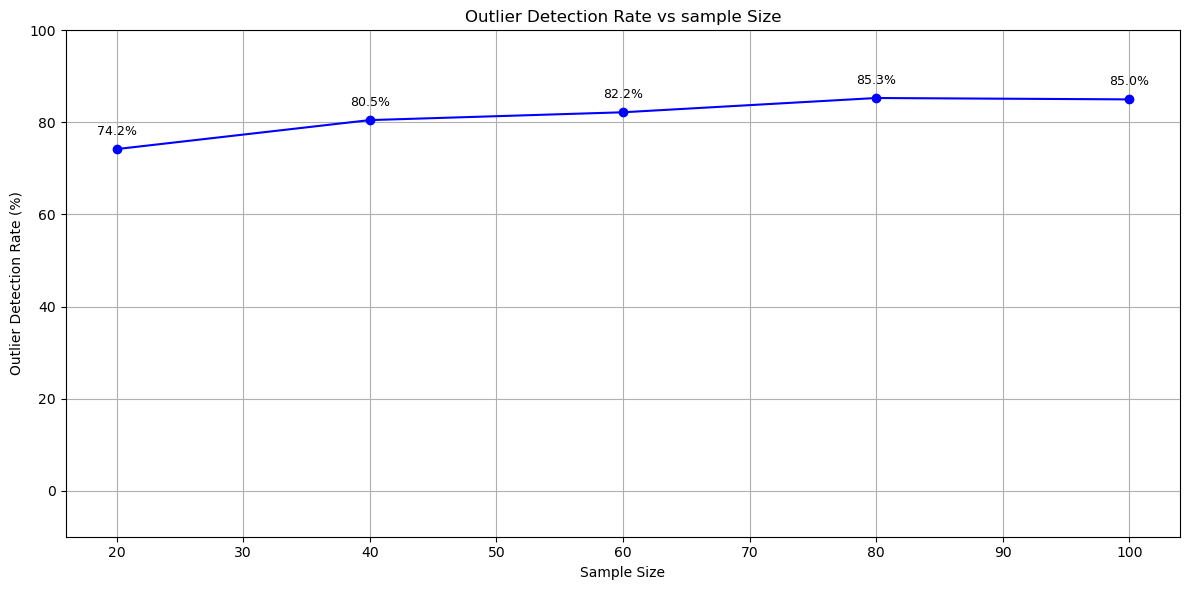

In [204]:
detection_rates = [(counts[size] / n_replicates) * 100 for size in subsample_sizes]

plt.figure(figsize=(12, 6))
plt.plot(subsample_sizes, detection_rates, marker='o', linestyle='-', color='blue')

for size, rate in zip(subsample_sizes, detection_rates):
    plt.annotate(
        f"{rate:.1f}%",
        (size, rate),    
        textcoords="offset points",  
        xytext=(0, 10),  
        ha='center',      
        fontsize=9       
    )

plt.xlabel('Sample Size')
plt.ylabel('Outlier Detection Rate (%)')
plt.title('Outlier Detection Rate vs sample Size')
plt.ylim(-10, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

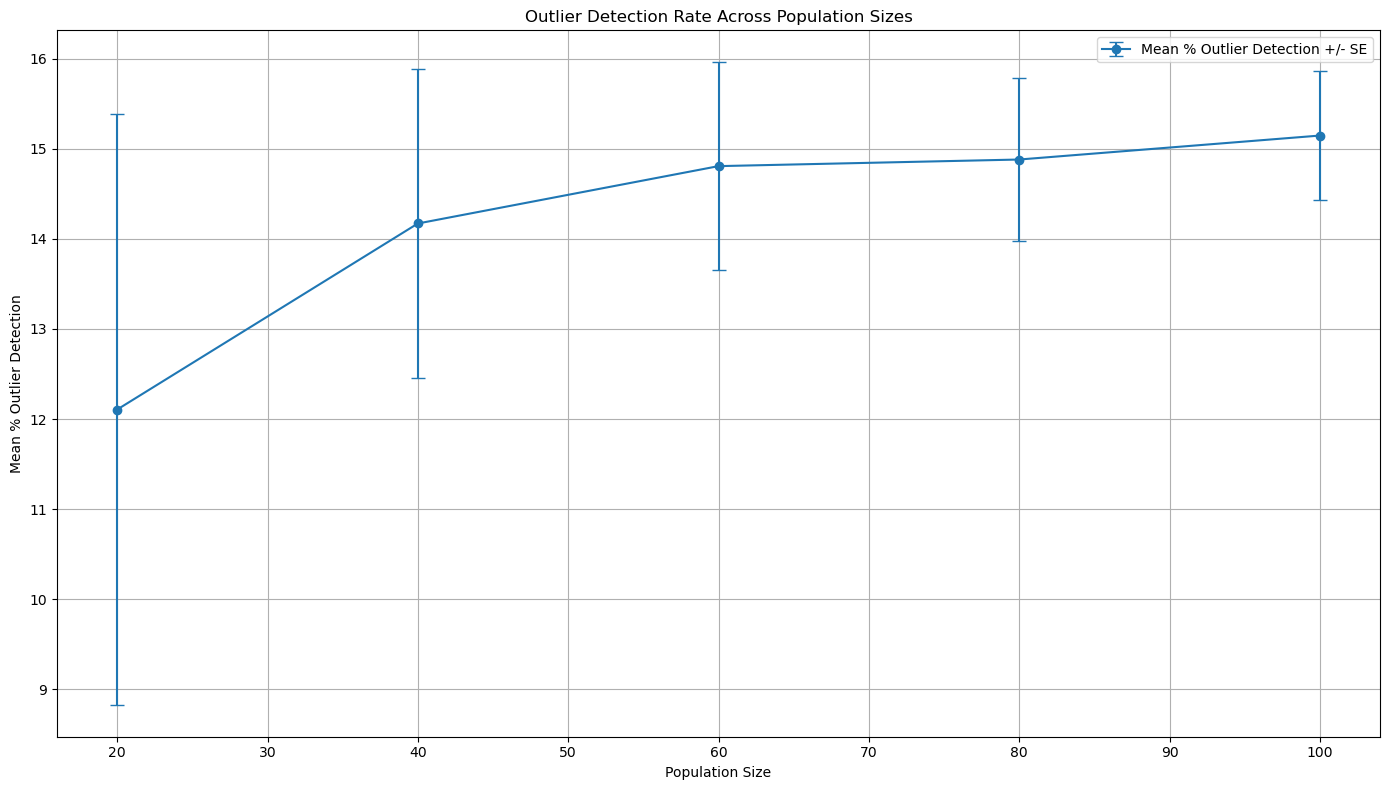

In [205]:
# (1) compute the percentage of time subject 1, 2, 3 etc were flagged outliers 
# (2) average these values along with the strandard error (for n=20, n=40, etc) and 
# (3) add the mean with standard error to the outlier detection plot
means, errors, pop_size = list(), list(), list()

for n, flags in id_dr.items():
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    se = np.std(percentages, ddof=1) / np.sqrt(len(flags))
    means.append(mean)
    errors.append(se)
    pop_size.append(n)

plt.figure(figsize=(14, 8))
plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, label='Mean % Outlier Detection +/- SE')
plt.title('Outlier Detection Rate Across Population Sizes')
plt.xlabel('Population Size')
plt.ylabel('Mean % Outlier Detection')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
